## Waiver Prediction Models
This shows some early attempts to predict by various models if a player would be waived, as well as to make probabilistic predictions of the same variable. We ultimately moved from this to player retention (i.e. if a player is in the league at all) as we found higher accuracy for that prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
player_data = pd.read_csv("train_data.csv")

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
class YearWiseStandardScaler(BaseEstimator,TransformerMixin):
    def __init__(self, year_column):
        self.year_column = year_column
        self.year_stats = {}
    def fit(self, X, y = None):
        grouped = X.groupby(self.year_column)
        for year, group in grouped:
            self.year_stats[year] = {
                "mean": group.mean(),
                "std": group.std(ddof=0), 
            }
        return self
    def transform(self, X):
        def scale_row(row):
            year = row[self.year_column]
            stats = self.year_stats[year]
            return (row - stats["mean"]) / stats["std"]

        scaled_data = X.apply(scale_row, axis=1)
        scaled_data = scaled_data.drop(columns=self.year_column)
        
        return scaled_data

In [4]:
#Checking that my YearWiseStandardScaler works
toy_data = {
    "Feature1": [1.5, 1.0, 2.4, 0.0, 8.1, 9.2],
    "Feature2": [10, 20, 30, 40, 50, 60],
    "Year": [2023, 2022, 2022, 2023, 2019, 2022]
}

In [5]:
toy_df = df = pd.DataFrame(toy_data)

In [6]:
scaler = YearWiseStandardScaler(year_column ="Year")
scaler.fit(toy_df)
scaled_df = scaler.transform(toy_df)
print(scaled_df)

   Feature1  Feature2
0  1.000000 -1.000000
1 -0.893497 -0.980581
2 -0.502592 -0.392232
3 -1.000000  1.000000
4       NaN       NaN
5  1.396089  1.372813


In [7]:
len(player_data)

11965

In [8]:
player_data['WAIVED_BY_START_OF_NEXT_SEASON'] = player_data[['WAIVED', 'RELEASED']].any(axis=1).astype(int)

In [9]:
player_data.sample()

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,...,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,IN_LEAGUE_NEXT,WAIVED_BY_START_OF_NEXT_SEASON
8100,William Bedford,76138,1991,['DET'],28.0,5.0,C,32.0,8.0,363.0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
player_data = player_data.dropna(subset=['SALARY'])

In [11]:
len(player_data)

11397

In [12]:
player_data = player_data[player_data['MIN'] != 0]

In [13]:
len(player_data)

11394

In [14]:
columns_to_normalize = ['FGM', 'FGA', 'PTS', 'PF', 'DREB', 'OREB', 'REB', 'FTA', 'FTM', 'STL', 'TOV', 'BLK', 'AST', 'FG3A', 'FG3M']

# Normalize the selected columns by dividing by 'MIN'
player_data[columns_to_normalize] = player_data[columns_to_normalize].div(player_data['MIN'], axis=0)

# Rename columns to include "per minute"
rename_dict = {col: f"{col} / MIN" for col in columns_to_normalize}
player_data.rename(columns=rename_dict, inplace=True)

In [15]:
player_data.sample()

,NAME,PLAYER_ID,SEASON_START,TEAMS_LIST,PLAYER_AGE,EXPERIENCE,POS,GP,GS,MIN,...,WAIVED_REG,WAIVED_POST,RELEASED_OFF,RELEASED_REG,RELEASED_POST,TRADED_OFF,TRADED_REG,TRADED_POST,IN_LEAGUE_NEXT,WAIVED_BY_START_OF_NEXT_SEASON
9516,Mike Conley,201144,2011,['MEM'],24.0,5.0,PG,62.0,61.0,2174.0,...,0,0,0,0,0,0,0,0,1,0


Now let's find the most correlated features

In [16]:
numeric_data = player_data.select_dtypes(include=['number'])

In [17]:
correlations = numeric_data.corr()['WAIVED_BY_START_OF_NEXT_SEASON']
sorted_correlations = correlations.sort_values(ascending=False)
pd.set_option('display.max_rows', None)

# Print the sorted correlations
print(sorted_correlations)

# Reset display options if needed
pd.reset_option('display.max_rows')

WAIVED_BY_START_OF_NEXT_SEASON    1.000000
WAIVED                            0.947449
WAIVED_REG                        0.795938
WAIVED_OFF                        0.571506
RELEASED                          0.325645
RELEASED_OFF                      0.295017
RELEASED_REG                      0.131331
PF / MIN                          0.106916
TOV_PERCENT                       0.106464
WAIVED_POST                       0.089167
PLAYER_AGE                        0.080225
RELEASED_POST                     0.063034
X3P_AR                            0.055353
PLAYER_ID                         0.034326
SEASON_START                      0.024243
TOV / MIN                         0.023506
TRADED_REG                        0.023022
FG3A / MIN                        0.020922
TRADED                            0.006751
EXPERIENCE                        0.005129
OREB / MIN                       -0.006836
STL_PERCENT                      -0.006875
F_TR                             -0.007385
STL / MIN  

Since player_ID is correlated at 10% despite being complete random, let's take anything that's correlated at 15% or higher

In [18]:
Xfeatures = ['GP', 'MIN', 'DWS', 'GS', 'WS', 'OBPM', 'BPM', 'PER', 'OWS', 'WS_48', 'FT_PCT', 'FG_PCT', 'FGM / MIN', 'PTS / MIN', 'VORP', 'TS_PERCENT', 'SALARY', 'FTM / MIN', 'USG_PERCENT', 'FTA / MIN', 'FGA / MIN' , 'SEASON_START']
len(Xfeatures)

22

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_player_data, test_player_data = train_test_split(player_data, test_size=0.2, stratify=player_data['WAIVED_BY_START_OF_NEXT_SEASON'], random_state=812)
print(len(train_player_data))
print(len(test_player_data))

9115
2279


In [21]:
train_player_data_waived = train_player_data.loc[train_player_data['WAIVED_BY_START_OF_NEXT_SEASON'] == 1]
train_player_data_unwaived = train_player_data.loc[train_player_data['WAIVED_BY_START_OF_NEXT_SEASON'] == 0]
p = len(train_player_data_waived)/len(train_player_data)
print(p)
print(p*(1 - p))
bbs = p*(1 - p)

0.11705979155238617
0.10335679675409806


About 11% of the players are waived, which is useful to have as a baseline for the various metrics. For instance, baseline accuracy would be p^2 + (1 - p)^2 which is about .8042.

We next look at some individual stats to determine what if there are statistically significant differences in the aggregate between the two classes of players. For example, in Field Goal percentage we get the following two charts:

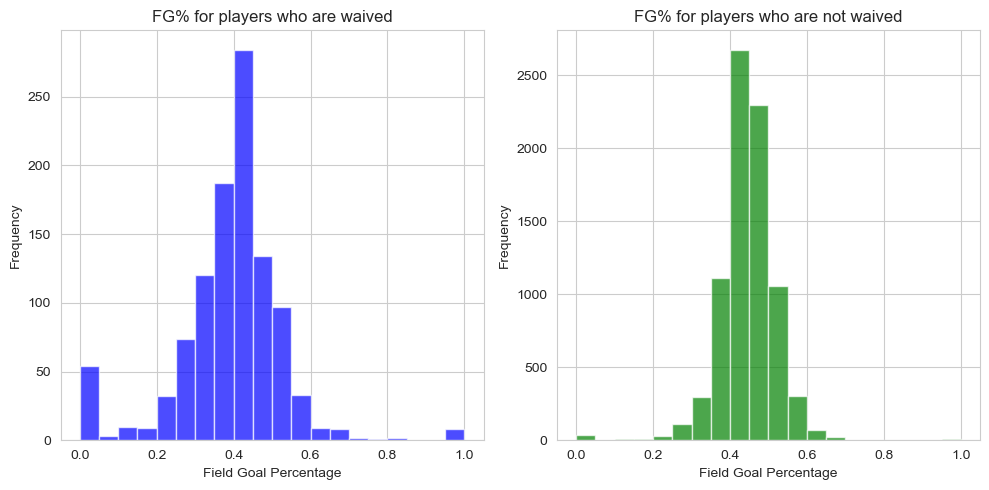

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_player_data_waived['FG_PCT'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('FG% for players who are waived')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_player_data_unwaived['FG_PCT'].dropna(), bins=20, color='green', alpha=0.7)
plt.title('FG% for players who are not waived')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
train_player_data_waived.loc[:, 'FG_PCT'].mean()

np.float64(0.38967197750702903)

In [24]:
train_player_data_unwaived.loc[:, 'FG_PCT'].mean()

np.float64(0.4449635934393638)

On the whole, this difference is highly statically significant. The p-value for a sample of unwaived players to have a FG% as low as unwaived players on average is extremely small.

In [25]:
from scipy import stats
unstandardizedZ = train_player_data_waived.loc[:,'FG_PCT'].mean()
mu = train_player_data_unwaived.loc[:, 'FG_PCT'].mean()
sigma = train_player_data_unwaived.loc[:, 'FG_PCT'].std()
size = len(train_player_data_waived)
standardizedZ = (size*unstandardizedZ - mu*size)/(np.sqrt(size)*sigma)
p_value = stats.norm.cdf(standardizedZ)
print(standardizedZ)
print(p_value)

-24.197331077533395
1.1867041057318453e-129


If there is more EDA stuff to add it should be added here.

Now we try some models to see how well the stats can predict at <i>an individual level</i> if a player will be waived or traded. We'll look at KNN classification, logistic classification, decision trees, and random forest classifiers. The metrics we are interested in are f1_score, accuracy_score, balanced_accuracy_score, and the brier score (with predict proba). Given the 11/89 split of waived and unwaived, the baseline metrics to compare to with a random guess that guesses a player will be waived with probability 11 would have metrics:

Accuracy: 0.7952 <br>
Balanced Accuracy: 0.5000 <br>
F1-Score: 0.1158 <br>
1 - Brier Score: 0.8976 <br>(Subtracting from 1 since a <i> smaller </i> Brier score is better.)

These are what we should compare our metrics against.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, brier_score_loss, balanced_accuracy_score

In [27]:

train_player_data = train_player_data.dropna(subset = Xfeatures)
print(len(train_player_data))
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=812, stratify = y)
knn_pipeline = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column = 'SEASON_START')),
    ('knn', KNeighborsClassifier(n_neighbors = 15))
])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Baseline F1 score: ", p)
print("Baseline Balanced Accuracy: .5")
print("Baseline Accuracy: ", p**2+(1 - p)**2)

9099
F1 score:  0.1984732824427481
Balanced Accuracy:  0.5538425739103797
Accuracy:  0.8846153846153846
Baseline F1 score:  0.11705979155238617
Baseline Balanced Accuracy: .5
Baseline Accuracy:  0.7932864064918037


In [28]:
y_prob = knn_pipeline.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)
print("Baseline Brier Score: ", bbs)

Brier Score:  0.08761416361416362
Brier Skill Score:  0.1523134775295777
Baseline Brier Score:  0.10335679675409806


In [29]:

metric_summary  = {
    "Metric": ["Accuracy", "Balanced Accuracy", "F1 Score", "1-Brier Score"],
    "KNN Model": [0.8846, 0.5538, 0.1985, 1-0.0876],
    "Baseline": [0.7952, 0.5000, 0.1158, 1-0.1024],
}

# Create a DataFrame
metrics_df = pd.DataFrame(metric_summary)
metrics_df

,Metric,KNN Model,Baseline
0,Accuracy,0.8846,0.7952
1,Balanced Accuracy,0.5538,0.5000
2,F1 Score,0.1985,0.1158
3,1-Brier Score,0.9124,0.8976


In [30]:
from sklearn.linear_model import LogisticRegression
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=813, stratify = y)


In [31]:
log_reg = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column = 'SEASON_START')),
    ('logreg', LogisticRegression(max_iter=10000))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.22302158273381295
Balanced Accuracy:  0.5622726429238378


In [32]:
y_prob = log_reg.predict_proba(X_test)

In [33]:

y_prob
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.08383540825767548
Brier Skill Score:  0.18887377617620071


In [34]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [35]:
#tree_cfr = Pipeline([(scaler = YearWiseStandardScaler(year_column = 'SEASON_START'), (classifier = DecisionTreeClassifier(max_depth=6, random_state=814)))])
tree_cfr = Pipeline([
    ('scaler', YearWiseStandardScaler(year_column='SEASON_START')),  
    ('classifier', DecisionTreeClassifier(max_depth = 6, random_state=814))  
])
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=815, stratify = y)
tree_cfr.fit(X_train, y_train)
y_pred = tree_cfr.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.2827586206896552
Balanced Accuracy:  0.5853478213485165


In [36]:
y_prob = tree_cfr.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.09570581321800904
Brier Skill Score:  0.07402496764960609


In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 50, 
    max_depth = 3, 
    max_features = 6, 
    bootstrap= True, 
    max_samples = 500,
    random_state = 816
    )
rf = Pipeline([('scaler', YearWiseStandardScaler(year_column='SEASON_START')), ('classifier', RandomForestClassifier(
    n_estimators = 50, 
    max_depth = 3, 
    max_features = 6, 
    bootstrap= True, 
    max_samples = 500,
    random_state = 816
    ))])

In [38]:
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=817, stratify = y)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.14937759336099585
Balanced Accuracy:  0.5389250041973614


In [39]:
y_prob = tree_cfr.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.07267239531529213
Brier Skill Score:  0.2968784095719308


Of the non-ensemble methods, the decision tree works best, so let's boost that one with AdaBoost

In [40]:
from sklearn.ensemble import AdaBoostClassifier

In [41]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                                n_estimators=100,
                                algorithm = 'SAMME',
                                learning_rate = 0.05,
                                random_state=818)
ada_clf = Pipeline([('scalar', YearWiseStandardScaler(year_column = 'SEASON_START')), ('classifier', AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                                n_estimators=100,
                                algorithm = 'SAMME',
                                learning_rate = 0.05,
                                random_state=818))])

In [42]:
X = train_player_data[Xfeatures]
y = train_player_data['WAIVED_BY_START_OF_NEXT_SEASON']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=817, stratify = y)
ada_clf.fit(X_train, y_train)

Pipeline(steps=[('scalar', YearWiseStandardScaler(year_column='SEASON_START')),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=6),
                                    learning_rate=0.05, n_estimators=100,
                                    random_state=818))])

In [43]:
y_pred = tree_cfr.predict(X_test)
f1score = f1_score(y_test, y_pred)
print("F1 score: ", f1score)
print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))

F1 score:  0.4261168384879725
Balanced Accuracy:  0.6413258949216345


In [44]:
y_prob = ada_clf.predict_proba(X_test)
y_prob = y_prob[:, 1]
brier_score = brier_score_loss(y_test, y_prob)
print("Brier Score: ", brier_score)
print("Brier Skill Score: ", 1 - brier_score/bbs)

Brier Score:  0.09067146246681075
Brier Skill Score:  0.12273343104341461
